# Exploring aggregate lengths of *n* consecutive iiLoci

Investigating different values of *n* to see if/when the distribution of consecutive iiLocus lengths approaches normal.
The first time you execute the notebook, you'll want to choose `Cell --> Run All`.
For subsequent executions, you'll want to edit the simple configuration cell and then while that cell is selected choose `Cell --> Run All Below`.

## Supporting code

Code for accumulating adjacent iiLoci, as well as the obligatory boilerplate code to make figures that don't look horrible.
Only extremely curious tinkerers will want to tread here.

In [8]:
from __future__ import print_function
%matplotlib inline

import glob
import matplotlib.pyplot as plt
import pandas
import seaborn
import numpy
from collections import deque
seaborn.set_context({"figure.figsize": (12, 8)})

In [3]:
def len_consec_iiloci(data, n=2, filt=None):
    """
    Compute combined lengths for each set of n consecutive iiLoci.

    Iterate over iiLoci, accumulating sets of n consecutive iiLoci in a deque
    and yield the aggregate length of each set of n. Reset the deque when a new
    sequence is encountered.
    
    `data` is a pandas.DataFrame object, each row corresponding to a single
    iiLocus.

    `filt` is an (optional) maximum length threshold. If set, iiLoci whose
    length exceeds the thredhold will be discarded.
    """
    iiloci = deque()
    for index, row in data.iterrows():
        if filt and row['Length'] > filt:
            continue
        if len(iiloci) > 0 and iiloci[0]['SeqID'] != row['SeqID']:
            iiloci = deque()
        iiloci.append(row)
        if len(iiloci) == n:
            aggregate_length = sum([ilocus['Length'] for ilocus in iiloci])
            yield aggregate_length
            iiloci.popleft()

In [4]:
def make_hist(data, log10=False, bins=40, xlab=None, ylab=None,
              xlim=None, ylim=None, title=None, color='grey'):
    if xlim:
        data = [dat for dat in data if dat < xlim[1]]
    if log10:
        _ = plt.hist(numpy.log10(data), bins=bins, color=color)
    else:
        _ = plt.hist(data, bins=bins, color=color)
    seaborn.despine(left=True)
    if xlab is not None:
        _ = plt.xlabel(xlab, fontsize=18)
    if ylab is not None:
        _ = plt.ylabel(ylab, fontsize=18)
    if xlim is not None:
        _ = plt.xlim(xlim[0], xlim[1])
    if ylim is not None:
        _ = plt.ylim(ylim[0], ylim[1])
    if title:
        plt.title(title, fontsize=20)
    plt.show()

## Configuration

Okay, here is where it gets interesting.
Specify what you want to look at with the configuration options below.

In [5]:
# Species (choices: Scer Cele Crei Mtru Agam Dmel Xtro Drer Mmus Hsap Pdom Dpul Vcar)
species = 'Mmus'

# Range of n values to consider
nrange = [2, 30, 60]

# The next line specifies the quantile at which outliers in the long tail of the
# length distribution will be discarded. Set it to None to disable the filter.
maxlenqnt = 0.95
# maxlenqnt = None


# The next line controls the x-axis range of viewing window, which can make a 
# difference (especially when the filter is disabled) in the histogram's
# resolution.
xrange = None
# xrange = [0, 100000]

You shouldn't have to touch anything below this line.
Once you've set the configuration values, go ahead and select that cell and then click `Cell --> Run All Below` in the menu above.

In [6]:
filename = '../data/{}/{}.iloci.tsv'.format(species, species)
iloci = pandas.read_csv(filename, sep='\t')
iiloci = iloci.loc[iloci.LocusClass == 'iiLocus']

maxlen = 0
if maxlenqnt:
    maxlen = int(iiloci['Length'].quantile(maxlenqnt))
    print('Max iiLocus length: {} bp'.format(maxlen))

Max iiLocus length: 243237 bp


In [7]:
iiloci.head()

,Species,LocusId,SeqID,LocusPos,Length,EffectiveLength,GCContent,GCSkew,NContent,LocusClass,GeneCount,SeqUnannot,FlankGeneOrient
3,Mmus,MmusILC-00004,NC_000067.6,NC_000067.6_3672779-4115172,442394,442394,0.387,-0.007,0.0,iiLocus,0,False,RR
5,Mmus,MmusILC-00006,NC_000067.6,NC_000067.6_4243866-4290345,46480,46480,0.394,-0.000,0.0,iiLocus,0,False,RR
7,Mmus,MmusILC-00008,NC_000067.6,NC_000067.6_4409767-4490427,80661,80661,0.407,-0.014,0.0,iiLocus,0,False,RR
9,Mmus,MmusILC-00010,NC_000067.6,NC_000067.6_4497887-4582626,84740,84740,0.416,-0.001,0.0,iiLocus,0,False,RR
12,Mmus,MmusILC-00013,NC_000067.6,NC_000067.6_4618306-4772697,154392,154392,0.412,0.001,0.0,iiLocus,0,False,FR


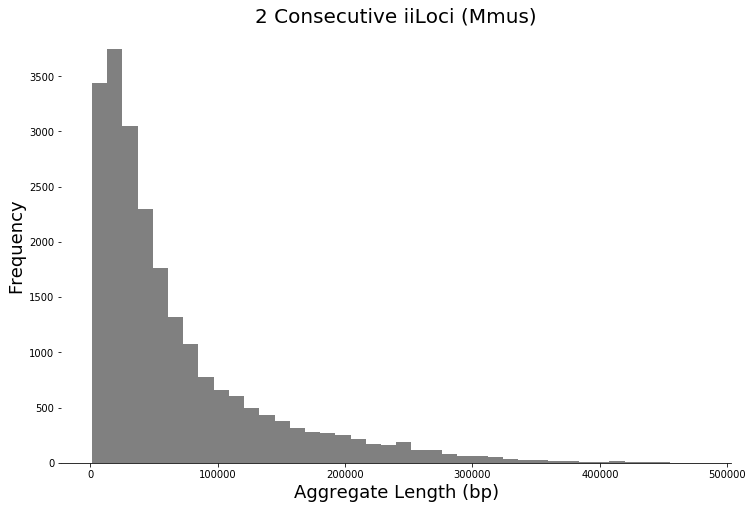

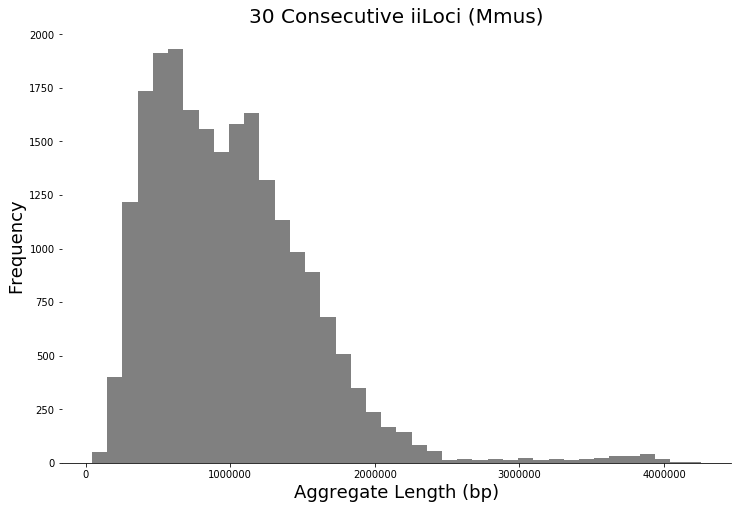

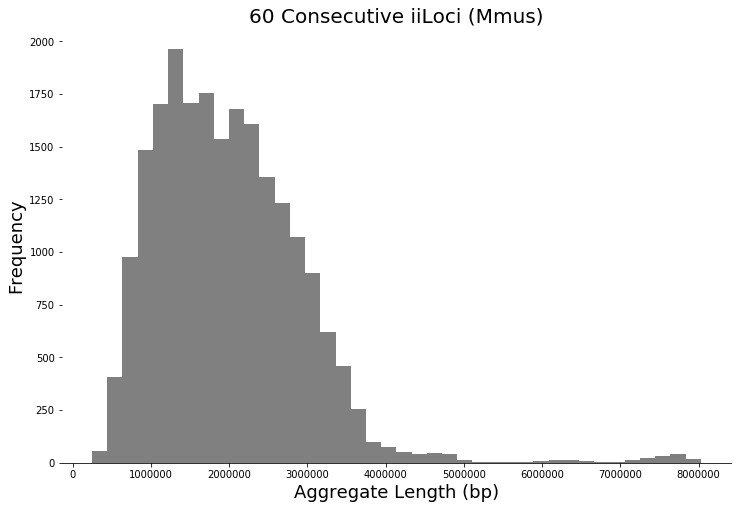

In [9]:
#for k in range(nrange[0], nrange[1] + 1):
for k in nrange:
    title = '{} Consecutive iiLoci ({})'.format(k, species)
    agglens = [x for x in len_consec_iiloci(iiloci, n=k, filt=maxlen)]
    make_hist(agglens, xlab='Aggregate Length (bp)', ylab='Frequency',
              title=title, xlim=xrange)

Max iiLocus length: 8620 bp


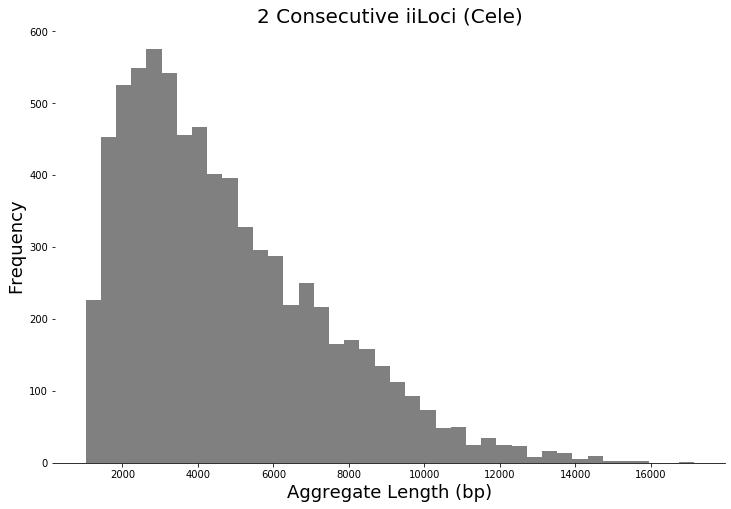

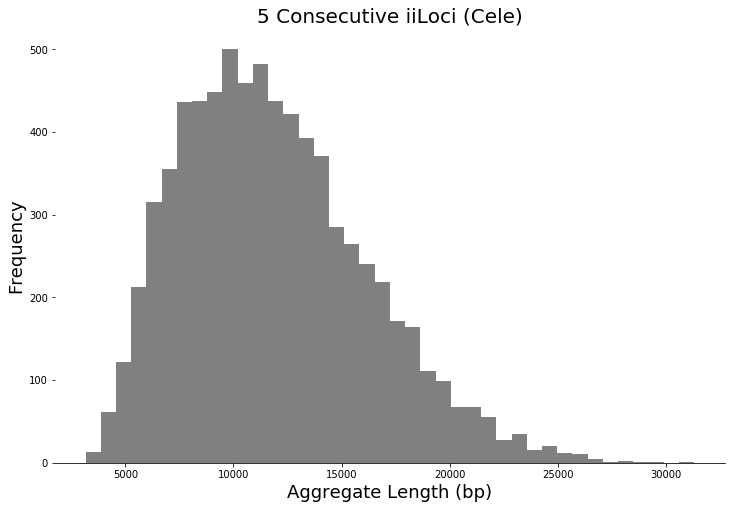

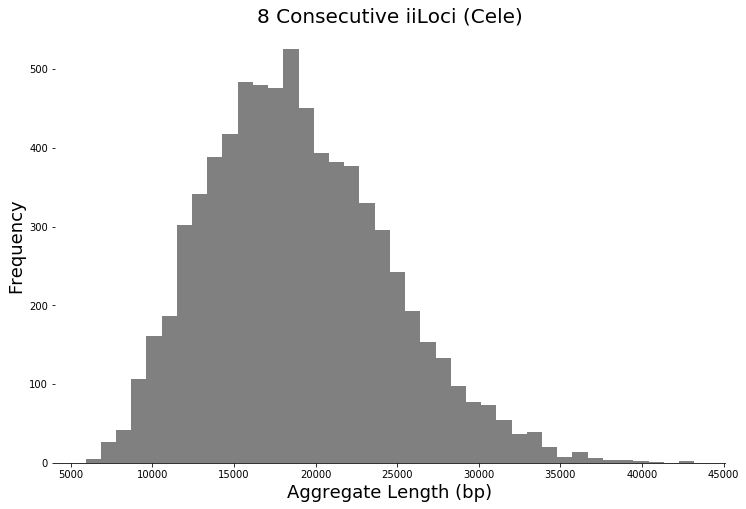

Max iiLocus length: 18271 bp


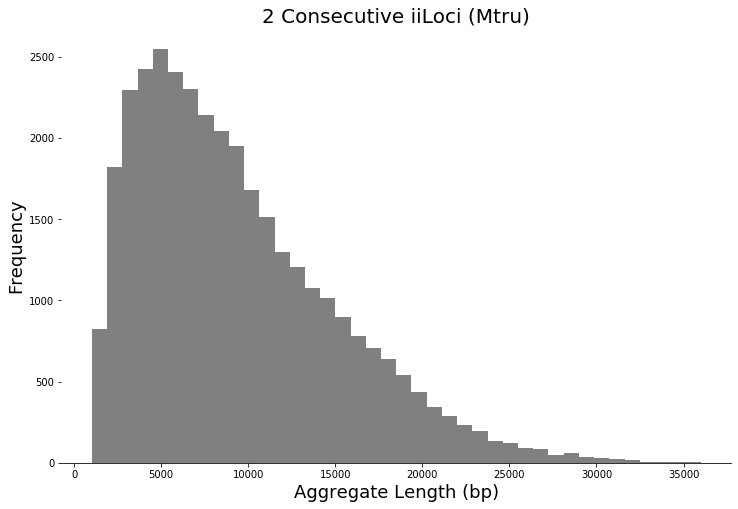

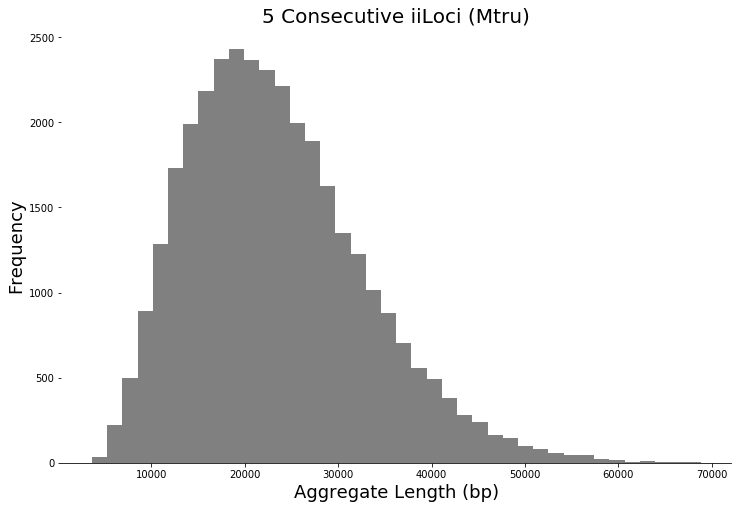

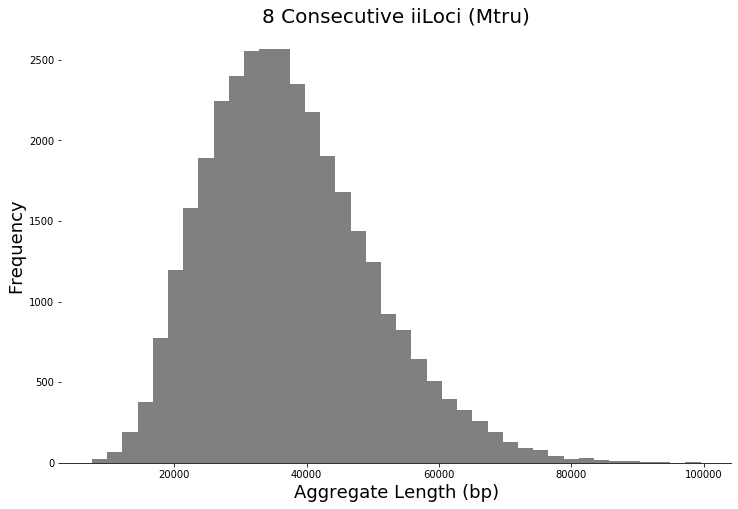

In [10]:
species_list = ['Cele','Mtru']
nrange = [2, 5, 8]
for species in species_list:
    filename = '../data/{}/{}.iloci.tsv'.format(species, species)
    iloci = pandas.read_csv(filename, sep='\t')
    iiloci = iloci.loc[iloci.LocusClass == 'iiLocus']

    maxlen = 0
    if maxlenqnt:
        maxlen = int(iiloci['Length'].quantile(maxlenqnt))
        print('Max iiLocus length: {} bp'.format(maxlen))
    for k in nrange:
        title = '{} Consecutive iiLoci ({})'.format(k, species)
        agglens = [x for x in len_consec_iiloci(iiloci, n=k, filt=maxlen)]
        make_hist(agglens, xlab='Aggregate Length (bp)', ylab='Frequency',
                  title=title, xlim=xrange)